# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import silhouette_score, adjusted_rand_score

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Объединяем данные
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
# PCA с 90% объясненной дисперсии
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [10]:
print(f"Количество компонент для объяснения 90% дисперсии: {pca.n_components_}")
print(f"\nОбъясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")

Количество компонент для объяснения 90% дисперсии: 65

Объясненная дисперсия: 0.9005


**Ответ: 65**

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [11]:
first_component_variance = pca.explained_variance_ratio_[0] * 100
print(f"Дисперсия первой главной компоненты: {first_component_variance:.2f}%")
print(f"Округленно: {round(first_component_variance)}%")

Дисперсия первой главной компоненты: 50.74%
Округленно: 51%


**Ответ: 51**

Визуализируйте данные в проекции на первые две главные компоненты.

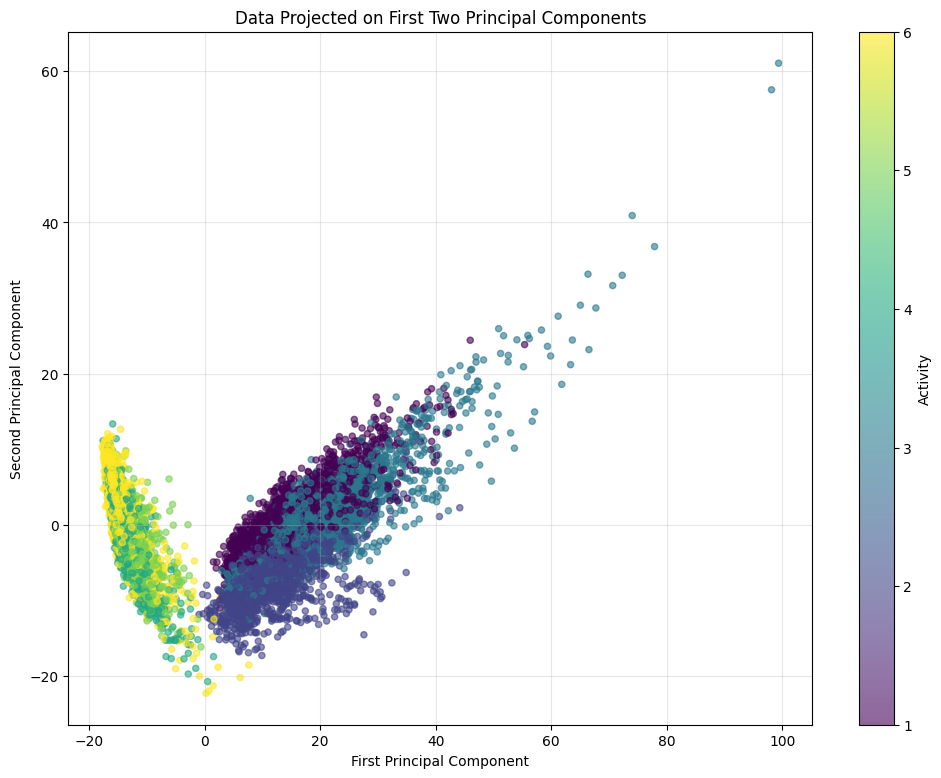

In [12]:
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Activity')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Data Projected on First Two Principal Components')
plt.grid(True, alpha=0.3)
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Ответ: 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [13]:
# Собственная имплементация KMeans
class MyKMeans:
    def __init__(self, n_clusters=6, max_iter=300, n_init=10, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        
    def _init_centroids(self, X, random_state):
        """Инициализация центроидов случайным выбором точек"""
        np.random.seed(random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]
    
    def _compute_distances(self, X, centroids):
        """Вычисление евклидовых расстояний от точек до центроидов"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.linalg.norm(X - centroid, axis=1)
        return distances
    
    def _assign_clusters(self, distances):
        """Присвоение точек к ближайшим центроидам"""
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        """Обновление центроидов как среднего по точкам в кластере"""
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = cluster_points.mean(axis=0)
        return centroids
    
    def _compute_inertia(self, X, labels, centroids):
        """Вычисление инерции (суммы квадратов расстояний до центроидов)"""
        inertia = 0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[i]) ** 2)
        return inertia
    
    def fit(self, X):
        """Обучение модели"""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        
        # Множественная инициализация
        for init in range(self.n_init):
            # Инициализация центроидов
            seed = self.random_state + init if self.random_state is not None else None
            centroids = self._init_centroids(X, seed)
            
            # Итерации EM-алгоритма
            for iteration in range(self.max_iter):
                # E-step: присвоение точек кластерам
                distances = self._compute_distances(X, centroids)
                labels = self._assign_clusters(distances)
                
                # M-step: обновление центроидов
                new_centroids = self._update_centroids(X, labels)
                
                # Проверка сходимости
                if np.allclose(centroids, new_centroids):
                    break
                    
                centroids = new_centroids
            
            # Вычисление инерции для текущей инициализации
            inertia = self._compute_inertia(X, labels, centroids)
            
            # Сохранение лучшего результата
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        
        self.centroids = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        
        return self
    
    def predict(self, X):
        """Предсказание кластеров для новых данных"""
        distances = self._compute_distances(X, self.centroids)
        return self._assign_clusters(distances)

In [14]:
# Собственная реализация
my_kmeans = MyKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)
my_cluster_labels = my_kmeans.labels_

print(f"Инерция (собственная реализация): {my_kmeans.inertia_:.2f}")

# Sklearn реализация
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

print(f"Инерция (sklearn): {kmeans.inertia_:.2f}")
print(f"\nРазница в инерции: {abs(my_kmeans.inertia_ - kmeans.inertia_):.2f}")

Инерция (собственная реализация): 2003577.56
Инерция (sklearn): 2003454.90

Разница в инерции: 122.66


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

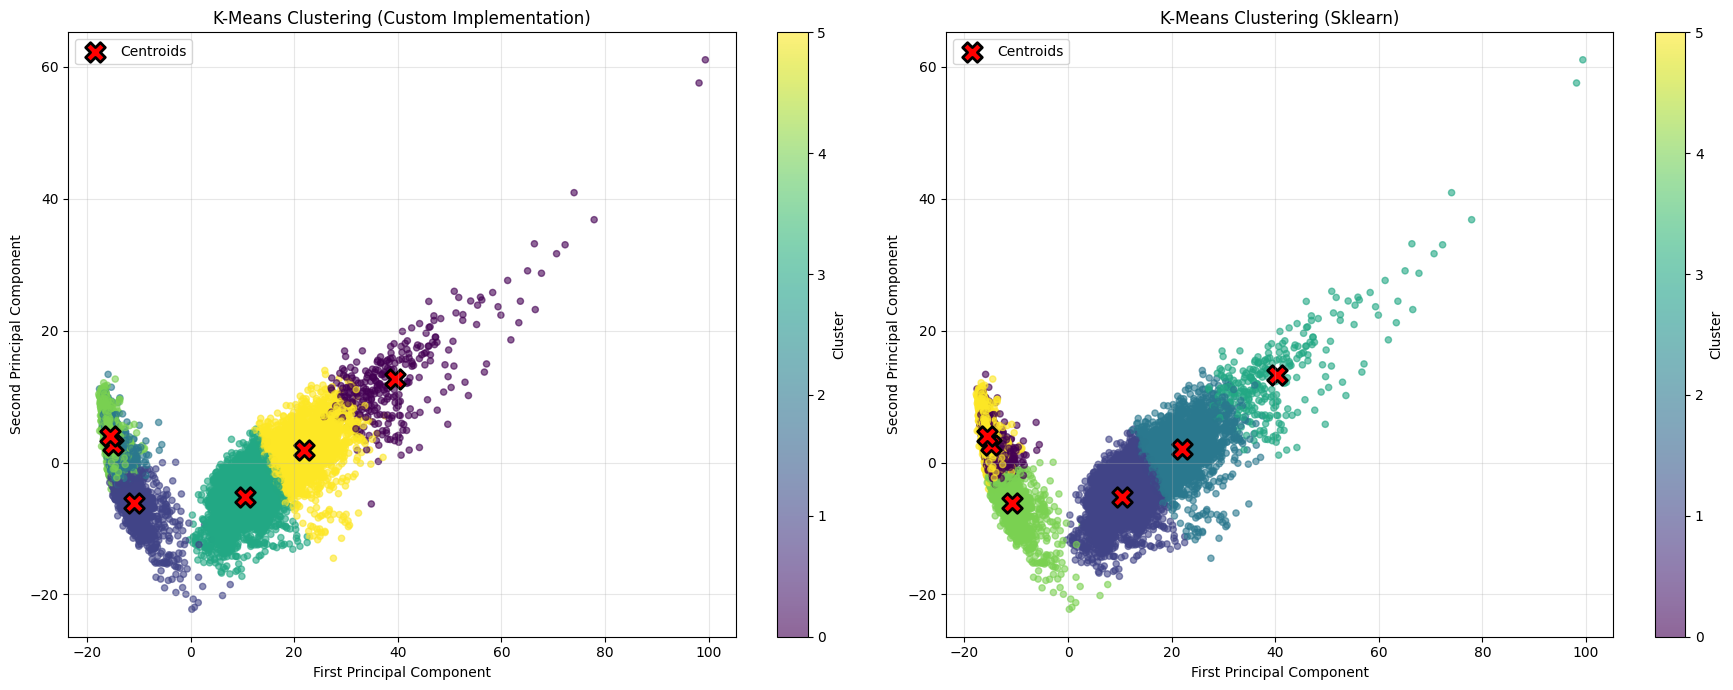

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Собственная реализация
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=my_cluster_labels, s=20, cmap='viridis', alpha=0.6)
axes[0].scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1], 
                c='red', s=200, marker='X', edgecolors='black', linewidths=2, label='Centroids')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('K-Means Clustering (Custom Implementation)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Sklearn реализация
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis', alpha=0.6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', s=200, marker='X', edgecolors='black', linewidths=2, label='Centroids')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title('K-Means Clustering (Sklearn)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

Посмотрите на соответствие между метками классов и метками кластеров. Для этого постройте crosstab (confusion matrix).

In [16]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       903       741        78         0   
подъем вверх по лестнице         0      1241       296         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                       1235         1         0         0       450   
стояние                       1344         0         0         0       562   
лежание                         52         5         0         0       329   
все                           2631      2470      1927       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                         91   1777  
стояние                          0   1906  
лежание                       1558   1944  
все                           1649  10299

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

In [17]:
# Вычисление максимальной доли для каждой активности
activities = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание']

max_ratios = []
for i in range(1, 7):
    activity_mask = y == i
    activity_clusters = cluster_labels[activity_mask]
    
    # Подсчет объектов в каждом кластере для данной активности
    cluster_counts = np.bincount(activity_clusters, minlength=n_classes)
    max_cluster_count = cluster_counts.max()
    total_count = activity_clusters.size
    
    max_ratio = max_cluster_count / total_count
    max_ratios.append(max_ratio)
    
    print(f"{activities[i-1]}: {max_ratio:.4f} ({max_cluster_count}/{total_count})")

best_activity_idx = np.argmax(max_ratios)
print(f"\nЛучше всего отделилась активность: {activities[best_activity_idx]}")

ходьба: 0.5244 (903/1722)
подъем вверх по лестнице: 0.8038 (1241/1544)
спуск по лестнице: 0.6330 (890/1406)
сидение: 0.6950 (1235/1777)
стояние: 0.7051 (1344/1906)
лежание: 0.8014 (1558/1944)

Лучше всего отделилась активность: подъем вверх по лестнице


**Ответ: подъем вверх по лестнице**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [18]:
# Метод локтя
inertia = []
silhouette_scores = []

for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans_temp.fit(X_pca)
    inertia.append(kmeans_temp.inertia_)
    
    # Silhouette score не определен для k=1
    if k > 1:
        silhouette_scores.append(silhouette_score(X_pca, kmeans_temp.labels_))
    else:
        silhouette_scores.append(0)

/tmp/ipykernel_227538/1118476695.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

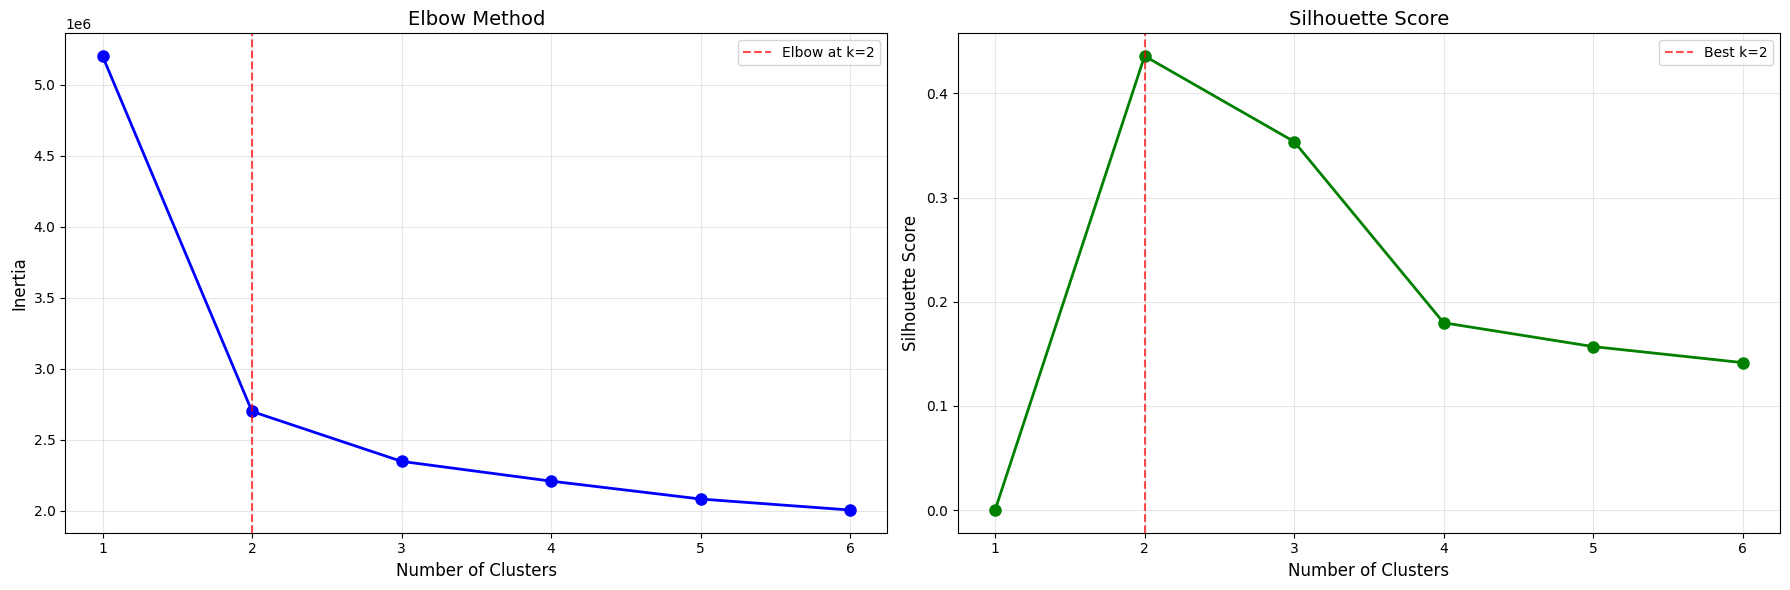

In [19]:
# Визуализация метода локтя и silhouette score
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# График инерции
axes[0].plot(range(1, n_classes + 1), inertia, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=2, color='red', linestyle='--', alpha=0.7, label='Elbow at k=2')
axes[0].legend()

# График silhouette score
axes[1].plot(range(1, n_classes + 1), silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14)
axes[1].grid(True, alpha=0.3)
best_k = np.argmax(silhouette_scores) + 1
axes[1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**Ответ: 2**

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [20]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [21]:
# ARI для KMeans
ari_kmeans = adjusted_rand_score(y, cluster_labels)
print(f"ARI для KMeans: {ari_kmeans:.4f}")

# ARI для Agglomerative Clustering
ari_ag = adjusted_rand_score(y, ag.labels_)
print(f"ARI для Agglomerative Clustering: {ari_ag:.4f}")

# Сравнение
print(f"\nРазница: {abs(ari_kmeans - ari_ag):.4f}")
if ari_ag > ari_kmeans:
    print("Agglomerative Clustering показал лучший результат")
else:
    print("KMeans показал лучший результат")

ARI для KMeans: 0.4198
ARI для Agglomerative Clustering: 0.4936

Разница: 0.0738
Agglomerative Clustering показал лучший результат


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответ:**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [22]:
# Стандартизация для классификации
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

In [23]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [24]:
# Grid Search
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1)
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=5000, random_state=17),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [25]:
print(f"Лучшие параметры: {best_svc.best_params_}")
print(f"Лучший score на кросс-валидации: {best_svc.best_score_:.4f}")

Лучшие параметры: {'C': 0.1}
Лучший score на кросс-валидации: 0.9380


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**Ответ: 0.1**

In [26]:
y_predicted = best_svc.predict(X_test_scaled)

In [27]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                         2                  0   
подъем вверх по лестнице      12                       459                  0   
спуск по лестнице              2                         4                413   
сидение                        0                         4                  0   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          508                       469                413   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   496  
подъем вверх по лестнице        0        0        0   471  
спуск по лестнице               1        0        0   420  
сидение                       426       61        0   491  
стояние                        15      517        0   532  
лежание                         0       11      526   537  
все                           442      589      526  2947

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [28]:
from sklearn.metrics import classification_report

# Детальный отчет
print(classification_report(y_test, y_predicted, 
                          target_names=['ходьба', 'подъем вверх', 'спуск', 'сидение', 'стояние', 'лежание']))

              precision    recall  f1-score   support

      ходьба       0.97      1.00      0.98       496
подъем вверх       0.98      0.97      0.98       471
       спуск       1.00      0.98      0.99       420
     сидение       0.96      0.87      0.91       491
     стояние       0.88      0.97      0.92       532
     лежание       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



**Ответ: по точности – стояние, по полноте – сидение**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [29]:
# PCA для классификации
pca_clf = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_clf.fit_transform(X_train_scaled)
X_test_pca = pca_clf.transform(X_test_scaled)

print(f"Количество компонент: {pca_clf.n_components_}")

# Grid Search с PCA
svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
best_svc_pca = GridSearchCV(svc_pca, svc_params, cv=3, n_jobs=-1, verbose=1)
best_svc_pca.fit(X_train_pca, y_train)

Количество компонент: 63
Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=5000, random_state=17),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [30]:
print(f"Лучшие параметры (с PCA): {best_svc_pca.best_params_}")
print(f"Лучший score на кросс-валидации (с PCA): {best_svc_pca.best_score_:.4f}")
print(f"Лучший score без PCA: {best_svc.best_score_:.4f}")

difference = abs(best_svc.best_score_ - best_svc_pca.best_score_) * 100
print(f"\nРазница в качестве: {difference:.2f}%")
print(f"Округленно: {round(difference)}%")

Лучшие параметры (с PCA): {'C': 0.1}
Лучший score на кросс-валидации (с PCA): 0.8984
Лучший score без PCA: 0.9380

Разница в качестве: 3.96%
Округленно: 4%


**Ответ: 4%**

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ:**
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

### Применение t-SNE для визуализации

Применяем t-SNE с perplexity=30...
Применяем t-SNE с perplexity=50...


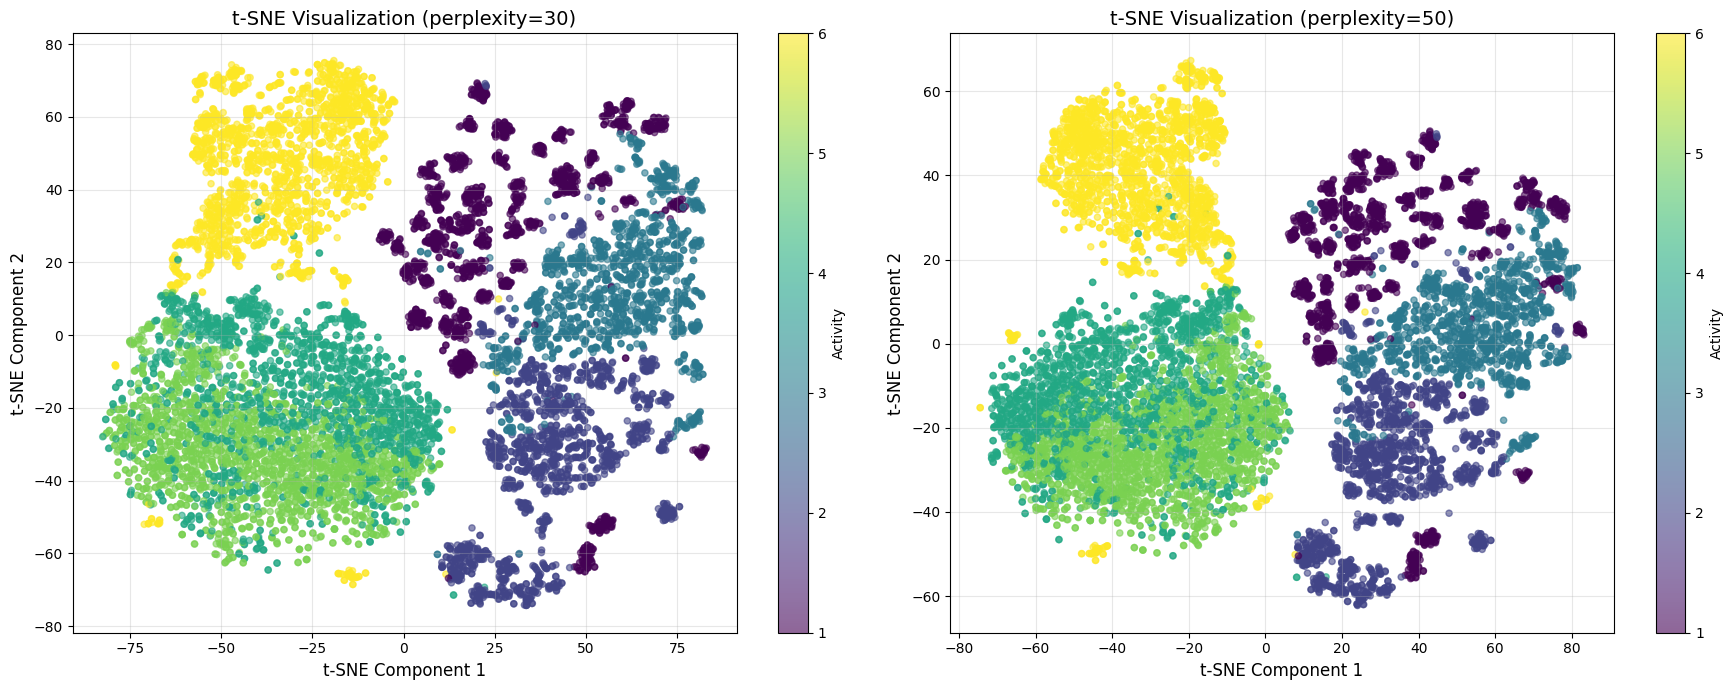

In [33]:
# t-SNE с различными параметрами perplexity
perplexities = [30, 50]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, perplexity in enumerate(perplexities):
    print(f"Применяем t-SNE с perplexity={perplexity}...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_pca)
    
    scatter = axes[idx].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis', alpha=0.6)
    axes[idx].set_xlabel('t-SNE Component 1', fontsize=12)
    axes[idx].set_ylabel('t-SNE Component 2', fontsize=12)
    axes[idx].set_title(f't-SNE Visualization (perplexity={perplexity})', fontsize=14)
    axes[idx].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[idx], label='Activity')

plt.tight_layout()
plt.show()

### Применение DBSCAN на PCA

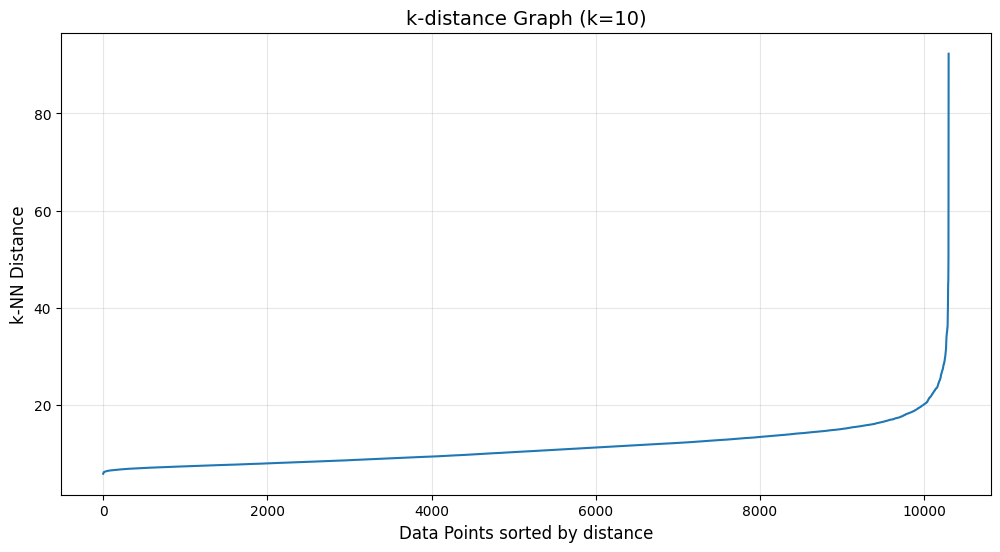

In [34]:
# Подбор параметров для DBSCAN
from sklearn.neighbors import NearestNeighbors

# Поиск оптимального eps используя k-distance график
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Сортируем расстояния
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.ylabel('k-NN Distance', fontsize=12)
plt.xlabel('Data Points sorted by distance', fontsize=12)
plt.title(f'k-distance Graph (k={k})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

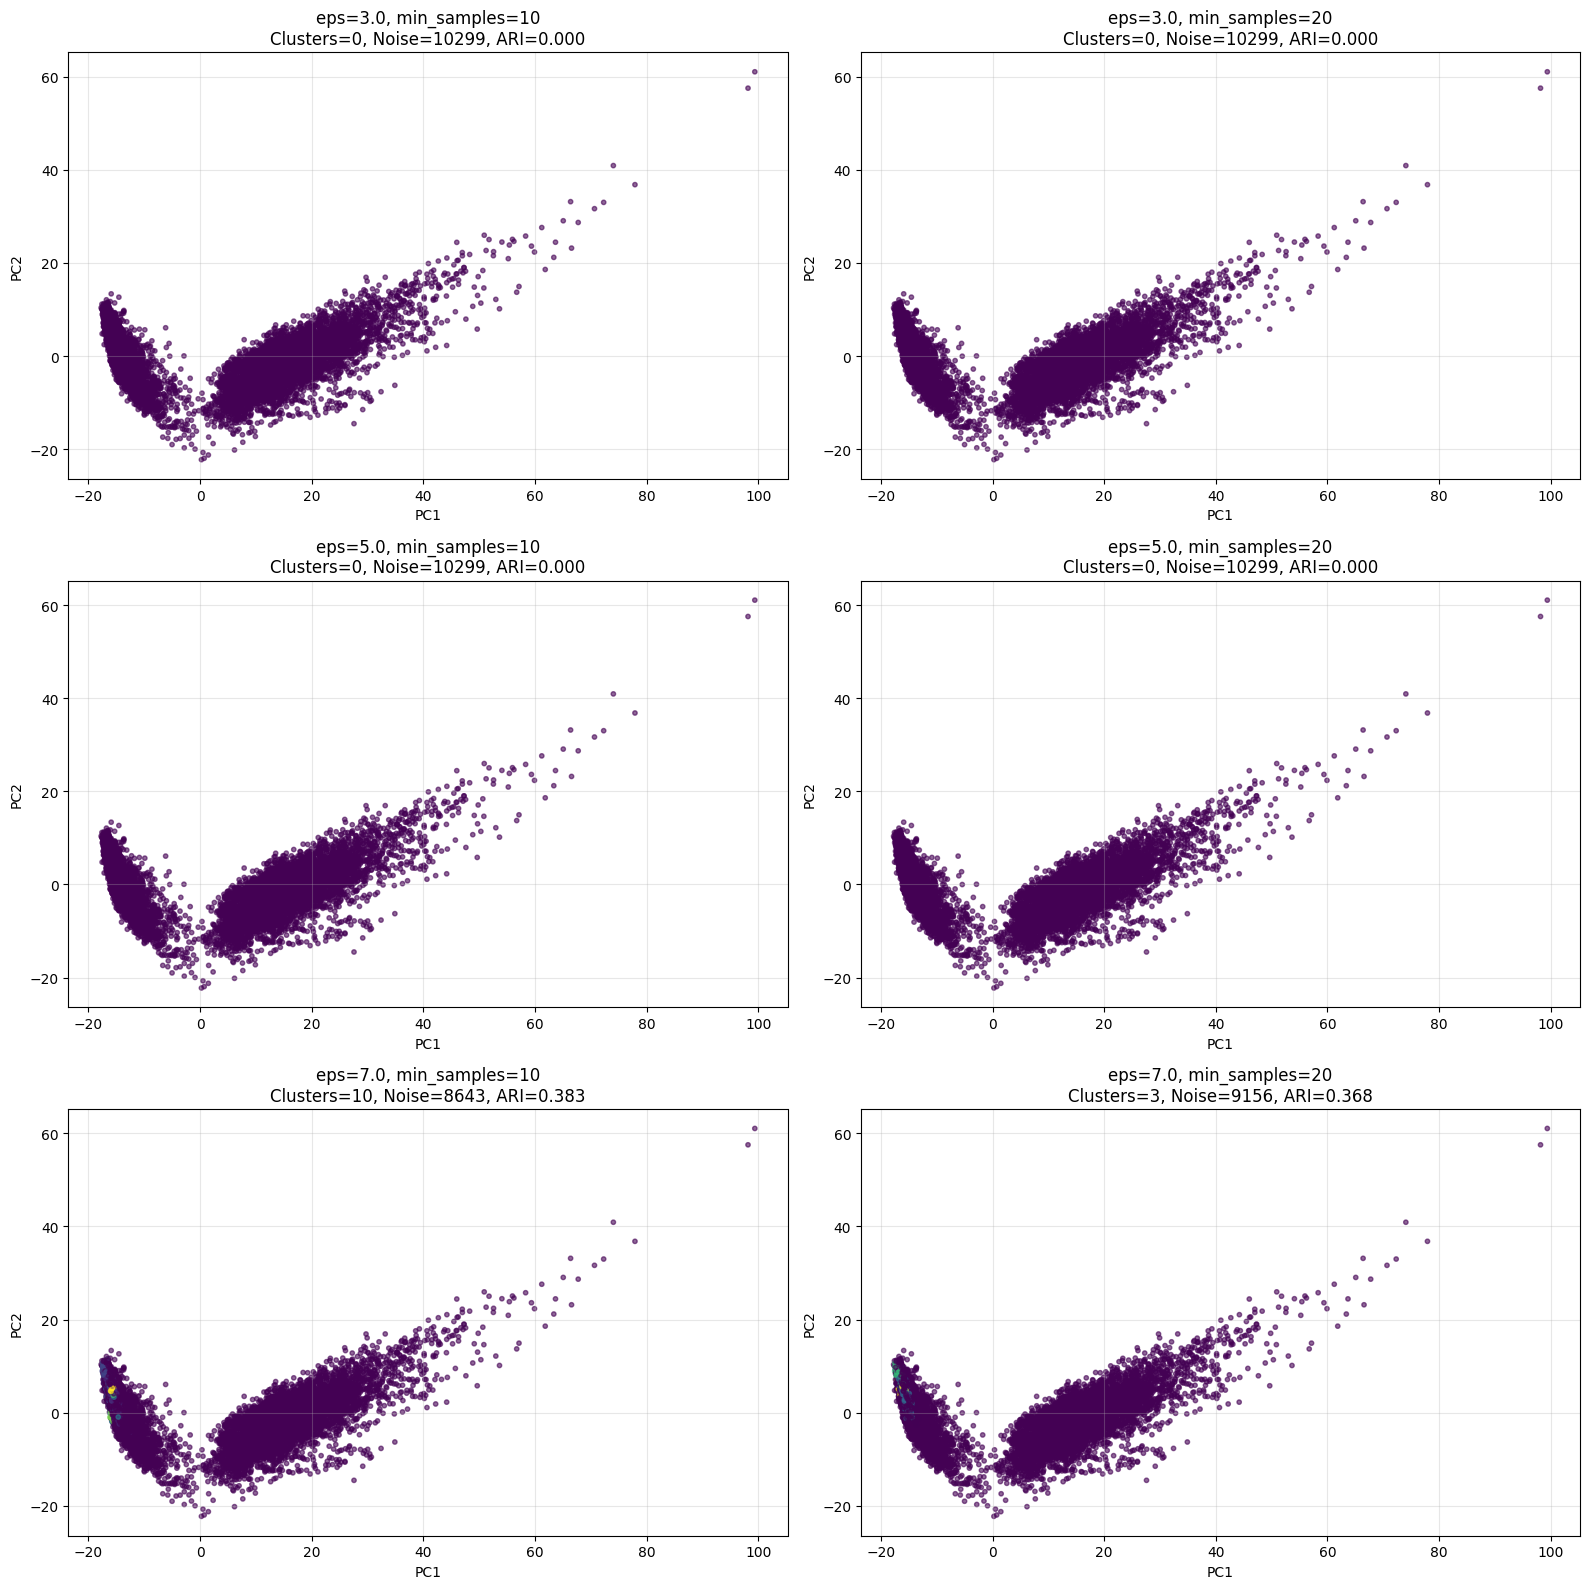


Результаты DBSCAN на PCA:
   eps  min_samples  n_clusters  n_noise       ari
0  3.0           10           0    10299  0.000000
1  3.0           20           0    10299  0.000000
2  5.0           10           0    10299  0.000000
3  5.0           20           0    10299  0.000000
4  7.0           10          10     8643  0.382874
5  7.0           20           3     9156  0.367700


In [35]:
# DBSCAN на PCA данных с различными параметрами
eps_values = [3.0, 5.0, 7.0]
min_samples_values = [10, 20]

fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(16, 16))

results = []

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # ARI только для не-шумовых точек
        if n_clusters > 0:
            mask = labels != -1
            if mask.sum() > 0:
                ari = adjusted_rand_score(y[mask], labels[mask])
            else:
                ari = 0
        else:
            ari = 0
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'ari': ari
        })
        
        # Визуализация
        ax = axes[i, j] if len(eps_values) > 1 else axes[j]
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
        ax.set_title(f'eps={eps}, min_samples={min_samples}\nClusters={n_clusters}, Noise={n_noise}, ARI={ari:.3f}')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим результаты
results_df = pd.DataFrame(results)
print("\nРезультаты DBSCAN на PCA:")
print(results_df)

### Применение DBSCAN на t-SNE

Применяем t-SNE для DBSCAN...


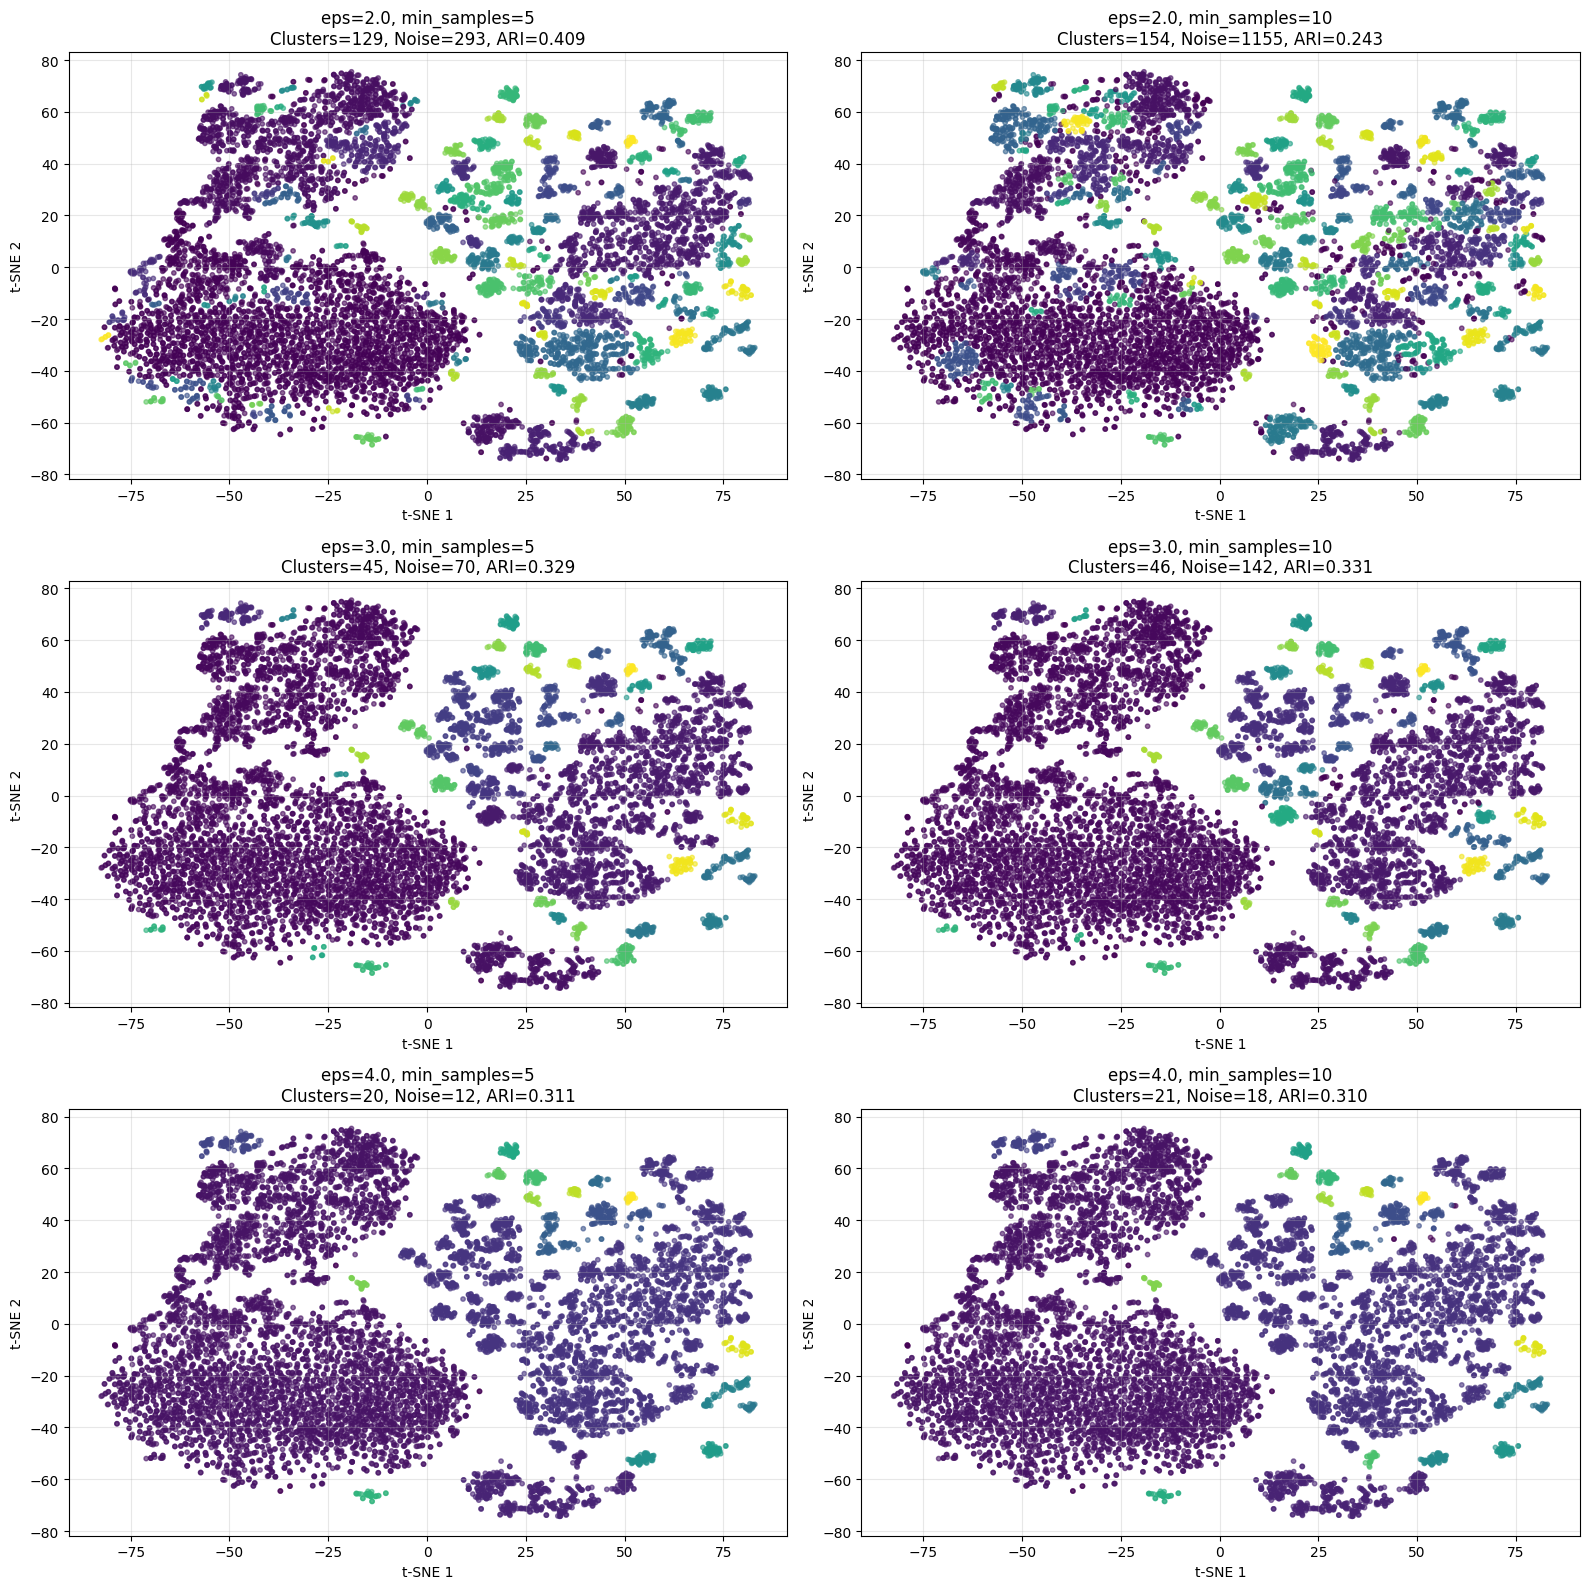


Результаты DBSCAN на t-SNE:
   eps  min_samples  n_clusters  n_noise       ari
0  2.0            5         129      293  0.408502
1  2.0           10         154     1155  0.242672
2  3.0            5          45       70  0.329071
3  3.0           10          46      142  0.330952
4  4.0            5          20       12  0.310527
5  4.0           10          21       18  0.310049


In [37]:
# Применяем t-SNE
print("Применяем t-SNE для DBSCAN...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# DBSCAN на t-SNE с различными параметрами
eps_values_tsne = [2.0, 3.0, 4.0]
min_samples_values_tsne = [5, 10]

fig, axes = plt.subplots(len(eps_values_tsne), len(min_samples_values_tsne), figsize=(16, 16))

results_tsne = []

for i, eps in enumerate(eps_values_tsne):
    for j, min_samples in enumerate(min_samples_values_tsne):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_tsne)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # ARI только для не-шумовых точек
        if n_clusters > 0:
            mask = labels != -1
            if mask.sum() > 0:
                ari = adjusted_rand_score(y[mask], labels[mask])
            else:
                ari = 0
        else:
            ari = 0
        
        results_tsne.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'ari': ari
        })
        
        # Визуализация
        ax = axes[i, j] if len(eps_values_tsne) > 1 else axes[j]
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
        ax.set_title(f'eps={eps}, min_samples={min_samples}\nClusters={n_clusters}, Noise={n_noise}, ARI={ari:.3f}')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим результаты
results_tsne_df = pd.DataFrame(results_tsne)
print("\nРезультаты DBSCAN на t-SNE:")
print(results_tsne_df)

### Сравнение результатов

In [38]:
# Находим лучшие параметры
best_pca_idx = results_df['ari'].idxmax()
best_tsne_idx = results_tsne_df['ari'].idxmax()

print("\n" + "="*50)
print("ЛУЧШИЕ РЕЗУЛЬТАТЫ")
print("="*50)
print("\nDBSCAN на PCA:")
print(results_df.loc[best_pca_idx])
print("\nDBSCAN на t-SNE:")
print(results_tsne_df.loc[best_tsne_idx])
print("\n" + "="*50)

# Сравнение с предыдущими методами
print(f"\nСравнение ARI:")
print(f"KMeans: {ari_kmeans:.4f}")
print(f"Agglomerative Clustering: {ari_ag:.4f}")
print(f"DBSCAN на PCA: {results_df.loc[best_pca_idx, 'ari']:.4f}")
print(f"DBSCAN на t-SNE: {results_tsne_df.loc[best_tsne_idx, 'ari']:.4f}")


ЛУЧШИЕ РЕЗУЛЬТАТЫ

DBSCAN на PCA:
eps               7.000000
min_samples      10.000000
n_clusters       10.000000
n_noise        8643.000000
ari               0.382874
Name: 4, dtype: float64

DBSCAN на t-SNE:
eps              2.000000
min_samples      5.000000
n_clusters     129.000000
n_noise        293.000000
ari              0.408502
Name: 0, dtype: float64


Сравнение ARI:
KMeans: 0.4198
Agglomerative Clustering: 0.4936
DBSCAN на PCA: 0.3829
DBSCAN на t-SNE: 0.4085
